# Introduction to Argoverse-depth map

This is a simple tutorial that will show you how to interact with the Argoverse-tracking dataset and **create depth maps for monocular depth estimation** using our python package. Please see our [Github page](https://github.com/argoai/argoverse-api) for instructions on how to install the package.

The Argoverse 3D-Tracking dataset can be downloaded at https://www.argoverse.org. This tutorial assumes that you have already downloaded and extracted all necessary data into a specific folder.

In [1]:
import os
import fnmatch
import glob

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.utils.camera_stats import RING_CAMERA_LIST

#### NOTE:

1. We'll define and use the **Lidar2Depth class** to project all Argoverse LiDAR sweeps onto corresponding ring camera images to obtain sparse depth ground truth. [We'll instantiate this class once for each log.](#Sample-execution)

2. Ground truth could be stored in a variety of formats, but we'll store integer-discretized depth as depth*256, to increase the range `from ~0.001 meters to int_max/256 meters`.

3. 0 meters is a privileged value that represents null ground truth. Unlike KITTI, we store depth, as opposed to disparity maps.

In [2]:
class Lidar2Depth:
    """
   Convert 360 degree LiDAR point cloud to depth map corresponding to each ring camera
   for monocular depth estimation.
    """

    def __init__(self, input_log_dir, output_save_path):
        """
        Args:
            input_log_dir : path to individual log dir (e.g. path/to/3d20ae25-5b29-320d-8bae-f03e9dc177b9/)
            output_save_path : path to output dir (e.g. path/to/depth_dataset/)
        """
        self.input_log_dir = input_log_dir
        self.output_save_path = output_save_path
        self.log_id = os.path.basename(input_log_dir)
        print("Log ID ", self.log_id)

        # Load Argo data
        dataset = os.path.dirname(self.input_log_dir)
        self.argoverse_loader = ArgoverseTrackingLoader(dataset)
        self.argoverse_data = self.argoverse_loader.get(self.log_id)

        # Count the number of LiDAR ply files in the log dir
        self.pylCounter = len(
            glob.glob1(os.path.join(self.input_log_dir, "lidar"), "*.ply")
        )

        # Setup depth dataset dir
        self.depth_data_dir_setup()

        # Extract depth data and ring camera frames
        self.depth_extraction()

        # Write path of rgb image, depth image along with focal length
        # in a txt file for data loader
        self.frame2depth_mapping()

    def depth_data_dir_setup(self):
        """
        Depth dataset structure
        +-- train/val
        |   +-- depth
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +-- 2.png
        |   |   |   |   +--   .
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +--            .
        |   |   +--            .
        |   +-- rgb
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right      
        |   |   +--            .
        |   |   +--            .           
            
        Args:
            None
            
        Returns:
            None
        """
        if fnmatch.fnmatchcase(self.input_log_dir, "*" + "train" + "*"):
            self.save_name = os.path.join(self.output_save_path, "train")
            self.logid_type = "train"

        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + "val" + "*"):
            self.save_name = os.path.join(self.output_save_path, "val")
            self.logid_type = "val"

        for camera_name in RING_CAMERA_LIST:
            paths = [
                os.path.join(self.save_name, "depth", self.log_id, camera_name),
                os.path.join(self.save_name, "rgb", self.log_id, camera_name),
            ]
            for sub_path in paths:
                if not os.path.exists(sub_path):
                    os.makedirs(sub_path)

    def extract_lidar_image_pair(self):
        """
        For the provided cameraID and LiDAR ply file, 
        extract rgb image and corresponding LiDAR points in the fov.
        
        Args:
            None
            
        Returns:
            None
        """

        self.img = self.argoverse_data.get_image_sync(
            self.lidar_frame_idx, camera=self.cameraID
        )

        objects = self.argoverse_data.get_label_object(self.lidar_frame_idx)
        self.calib = self.argoverse_data.get_calibration(self.cameraID)

        pc = self.argoverse_data.get_lidar(self.lidar_frame_idx)
        uv = self.calib.project_ego_to_image(pc).T
        lidar_frame_idx_ = np.where(
            np.logical_and.reduce(
                (
                    uv[0, :] >= 0.0,
                    uv[0, :] < np.shape(self.img)[1] - 1.0,
                    uv[1, :] >= 0.0,
                    uv[1, :] < np.shape(self.img)[0] - 1.0,
                    uv[2, :] > 0,
                )
            )
        )
        self.lidar_image_projection_points = uv[:, lidar_frame_idx_]

        if self.lidar_image_projection_points is None:
            print("No point image projection")
            return

    def save_image_pair(self):
        """
        Save the depth images and camera frame to the created dataset dir.
        
        Args:
            None
            
        Returns:
            None
        """
        x_values = np.round(self.lidar_image_projection_points[0], 0).astype(int)
        y_values = np.round(self.lidar_image_projection_points[1], 0).astype(int)
        lidar_depth_val = self.lidar_image_projection_points[2]

        # Create a blank image to place lidar points as pixels with depth information
        blank_img = np.zeros([self.img.shape[0], self.img.shape[1]], dtype=np.uint16)
        blank_img[y_values, x_values] = lidar_depth_val

        # Multiple to maintain precision, while model training, remember to divide by 256
        # NOTE: 0 denotes a null value, rather than actually zero depth in the saved depth map
        depth_scaled = blank_img * 256.0
        depth_scaled = depth_scaled.astype(np.uint32)
        depth_scaled = Image.fromarray(depth_scaled)
        raw_depth_path = os.path.join(
            self.save_name,
            "depth",
            self.log_id,
            str(self.cameraID),
            str(self.lidar_frame_idx) + ".png",
        )
        depth_scaled.save(raw_depth_path)  # Save Depth image

        img_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        raw_img_path = os.path.join(
            self.save_name,
            "rgb",
            self.log_id,
            str(self.cameraID),
            str(self.lidar_frame_idx) + ".png",
        )
        cv2.imwrite(
            raw_img_path, img_rgb, [cv2.IMWRITE_PNG_COMPRESSION, 0]
        )  # Save RGB image

    def depth_extraction(self):
        """
        For every lidar file, extract ring camera frames and store it in the save dir
        along with depth map
        
        Args:
            None
            
        Returns:
            None
        """
        for lidar_frame_idx in tqdm(range(self.pylCounter)):
            for cameraID in RING_CAMERA_LIST:
                self.cameraID = cameraID
                self.lidar_frame_idx = lidar_frame_idx
                # Extract camera frames and associated lidar points
                self.extract_lidar_image_pair()
                # Save the above extracted images
                self.save_image_pair()

    def frame2depth_mapping(self):
        """
        For your training dataloader, you will likely find it helpful to read image paths
        from a .txt file. In this final cell, we explicitly write to a .txt file all rgb 
        image paths that have a corresponding sparse ground truth depth file.
        
        Args:
            None
            
        Returns:
            None

        """
        mapping_file = open(
            os.path.join(
                output_save_path, "argo_" + self.logid_type + "_files_with_gt.txt"
            ),
            "w",
        )
        assert self.calib.fv == self.calib.fu, "different x and y focal lengths"
        for lidar_frame_idx in range(self.pylCounter):
            for cameraID in RING_CAMERA_LIST:
                file_path = os.path.join(
                    str(self.log_id), cameraID, str(lidar_frame_idx) + ".png"
                )
                gt_string = (
                    file_path + " " + file_path + " " + str(np.round(self.calib.fv, 4))
                )
                mapping_file.write(gt_string + "\n")

#  Sample execution

**Argoverse 3D Tracking v1.1** comes in 4 training parts and 1 validation. After downloading from [Argoverse](https://www.argoverse.org/data.html), extract and edit `folders` with absolute or relative paths. `output_save_path` is where depth dataset will be created, modify it to your need. 

Along with the above changes, add the absolute path for the repeated_logs. A portion of the path is already complted. Comments show the logIDs of the corresponding repetition. 

NOTE: Please remember to remove the break statements to run on all the logs. 

### Your inputs are needed in the below cell

In [3]:
# Modify paths here,
##################################################################################################################
folders = [
    "./Argoverse/full_data/extracted/argoverse-tracking/train1/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train2/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train3/",
    "./Argoverse/full_data/extracted/argoverse-tracking/train4/",
    "./Argoverse/full_data/extracted/argoverse-tracking/val/",
]
output_save_path = "./Argoverse/depth_dataset/"


# Cleanup - There are few logs that are repeated, they will be skipped.
# train3/49d66e75-3ce6-316b-b589-f659c7ef5e6d = train4/49d66e75-3ce6-316b-b589-f659c7ef5e6d
# train2/02cf0ce1-699a-373b-86c0-eb6fd5f4697a = train3/02cf0ce1-699a-373b-86c0-eb6fd5f4697a
# val/00c561b9-2057-358d-82c6-5b06d76cebcf = train3/00c561b9-2057-358d-82c6-5b06d76cebcf

# NOTE: PROVIDE ABSOLUTE PATH HERE
repeated_logs = (
    "/ABSOLUTE/PATH/HERE/Argoverse/full_data/extracted/argoverse-tracking/train3/49d66e75-3ce6-316b-b589-f659c7ef5e6d"
    "/ABSOLUTE/PATH/HERE/Argoverse/full_data/extracted/argoverse-tracking/train2/02cf0ce1-699a-373b-86c0-eb6fd5f4697a"
    "/ABSOLUTE/PATH/HERE/Argoverse/full_data/extracted/argoverse-tracking/val/00c561b9-2057-358d-82c6-5b06d76cebcf"
)
##################################################################################################################

# Filtering
log_list = []
for folder in folders:
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    log_list.extend(subfolders)
filtered_log_list = [log_path for log_path in log_list if log_path not in repeated_logs]
filtered_log_list.sort()

#### Start depth map extraction

In [4]:
# Start data extraction
for input_log_dir in filtered_log_list:
    Lidar2Depth(input_log_dir, output_save_path)
    break  # Remove break to run on all the logids

Log ID  043aeba7-14e5-3cde-8a5c-639389b6d3a6


100%|██████████| 157/157 [04:43<00:00,  1.80s/it]


## Visualize

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


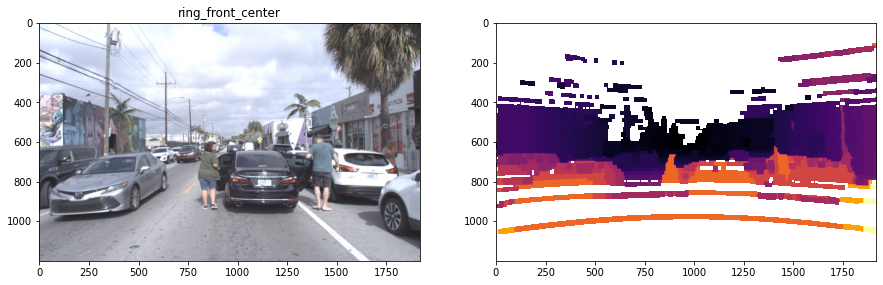

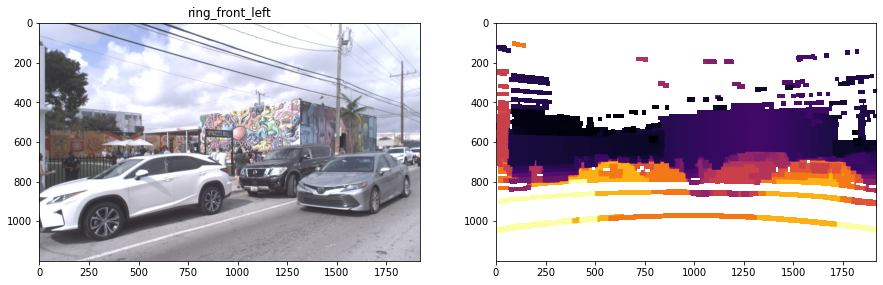

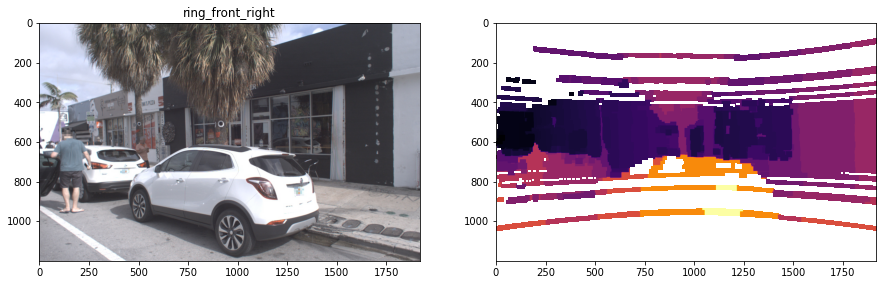

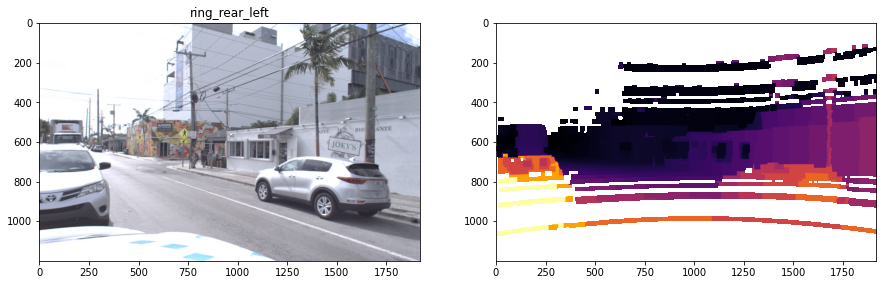

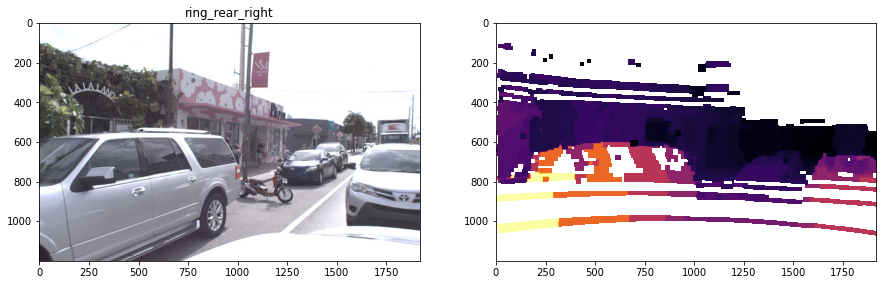

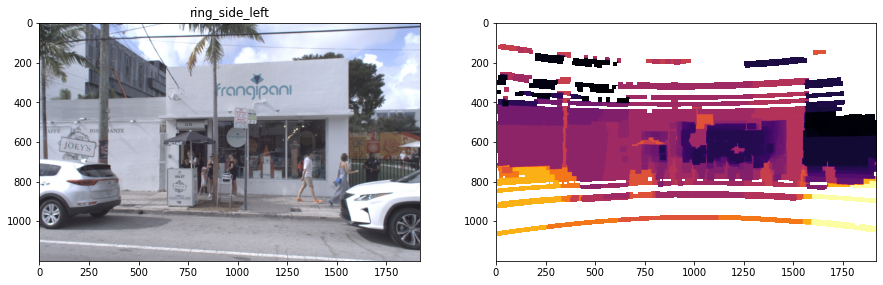

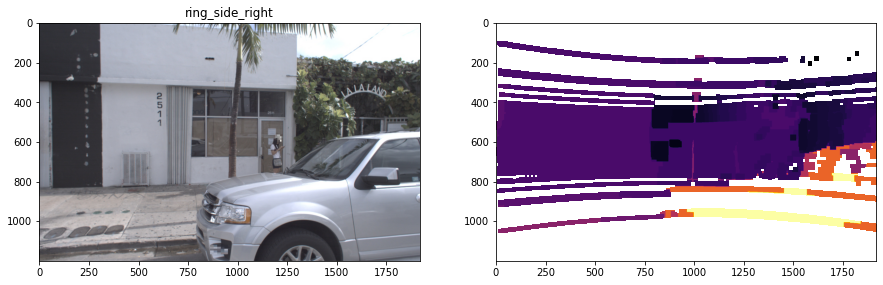

In [5]:
def display_depthmap(img_name, log_id, data_path):
    for cameraID in RING_CAMERA_LIST:
        # Load images
        rgb_image_path = os.path.join(data_path, "rgb", log_id, cameraID, img_name)
        depth_image_path = os.path.join(data_path, "depth", log_id, cameraID, img_name)
        rgb_image = cv2.cvtColor(
            cv2.imread(rgb_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB
        )
        depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) / 256
        # Dilate for better visualization
        dilated_depth_image = cv2.dilate(
            depth_image, kernel=np.ones((2, 2), np.uint8), iterations=30
        )

        plt.figure(figsize=(15, 7))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.title(cameraID)
        plt.subplot(122)
        plt.imshow(1 / dilated_depth_image, cmap="inferno")
        plt.show()


# Provide image name, log_id and data_path (either train or val path) to see the depth map from all the ring cameras
img_name = "30.png"
log_id = "043aeba7-14e5-3cde-8a5c-639389b6d3a6"
data_path = "./Argoverse/depth_dataset/train/"
display_depthmap(img_name, log_id, data_path)

<div align="center">
<b> Now use the above data to train your monocular depth estimation model and show us what you can build using our data </b>
</div>